In [1]:
# Disable version warnings
import os
import warnings
warnings.simplefilter('ignore', category=FutureWarning)
# Package setup
import glob
import logging
import scanpy as sc

# Change to source directory
os.chdir('../')
# Import expert functions
from src.utils.constants import TRAINING_KEYS
from src.models._expert import ExPert
# Import model run functions
import src.utils.io as io
from src.tune.run import train, full_run

# Setup logger
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

### I/O

In [ ]:
# Set training and testing data directory
work_dir = 'path/to/work_dir'                 # Replace with path to your data directory
train_dir = os.path.join(work_dir, 'train')
test_dir = os.path.join(work_dir, 'test')
# Set model output directory
model_dir = os.path.join(work_dir, 'models', 'small')
os.makedirs(model_dir, exist_ok=True)
# Set training path
train_p = os.path.join(train_dir, 'shared_contexts', 'top_100_no_ctrl.h5ad')               # Select a training adata
#train_p = os.path.join(train_dir, 'shared_contexts', 'nctx:5_ncls:572_minms:2_minc:100_minctx:4.h5ad')

# Set testing path
test_p = os.path.join(test_dir, 'jurkat.h5ad')                                      # Select a testing adata
# Set path to config
config_p = '../resources/params/runs/test/test.yaml'
# Set path to gene summary texts
#cls_texts_p = '../resources/gene_embeddings/claude_sonnet_4.5/gene_description_database.json'
cls_texts_p = '../resources/gene_embeddings/claude_sonnet_4.5/gene_descriptions_150.json'

### Train model

[12/12/25 22:20:14] INFO     Loading config file: ../resources/params/runs/test/test.yaml

                    INFO     Run output directory:                                                                 
                             /home/xlv0877/proj_home/dl/data/merge/8a2a33dfa4d9a069/models/small/test

                    INFO     Reading training data from:                                                           
                             /home/xlv0877/proj_home/dl/data/merge/8a2a33dfa4d9a069/train/shared_contexts/top_100_n
                             o_ctrl.h5ad

[12/12/25 22:20:16] INFO     Setting up model.

                    INFO     Registered class embedding from adata.uns[cls_embedding].

                    INFO     Registered context embedding from adata.uns[ctx_embedding].

                    WARNING  Specified control label None is not in adata class labels, ignoring parameter.

                    INFO     Registered 146 class texts.

[12/12/25 22:20:18] INFO     Registered frozen text embeddings.

                    INFO     [Hierarchy] Pathways: 88 | Modules: 109

                    INFO     Hierarchical labels computed:

                    INFO       Total genes: 146

                    INFO          Observed genes: 99

                    INFO          Unseen genes: 47

                    INFO       Total modules: 109

                    INFO          Observed modules: 75

                    INFO          Unseen modules: 34

                    INFO       Total pathways: 88

                    INFO          Observed pathways: 64

                    INFO          Unseen pathways: 24

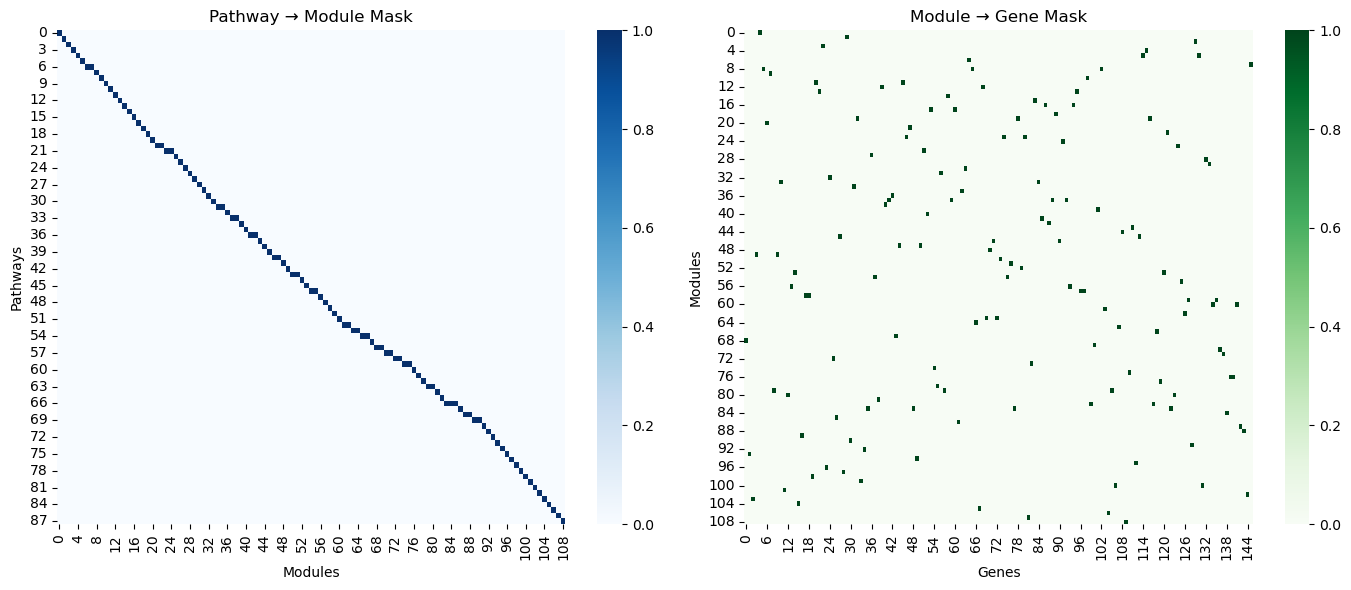

XPert(
  (_embeddings_dict): ModuleDict(
    (batch): Embedding(5, 5)
  )
  (z_encoder): Encoder(
    (encoder): AttentionLayers(
      (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (encoder): FunnelFCLayers(
        (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0): Block(
            (block): Sequential(
              (0): Linear(in_features=5783, out_features=128, bias=True)
              (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (2): GELU(approximate='none')
              (3): Dropout(p=0.2, inplace=False)
            )
          )
        )
      )
      (layers): ModuleList(
        (0-1): 2 x TransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (ff): Sequential(
            (0): Linear(in_features=128, out_features=256, bias=True)
          

[12/12/25 22:20:19] INFO     Running at: /home/xlv0877/proj_home/dl/data/merge/8a2a33dfa4d9a069/models/small/test

                    INFO     Epochs suggested: 97, training for 1200 epochs.

                    INFO     Using ['CD4-positive, alpha-beta T cell'] as test context(s).

                    INFO     Saving model checkpoints to:                                                          
                             /home/xlv0877/proj_home/dl/data/merge/8a2a33dfa4d9a069/models/small/test/lightning_log
                             s/version_233/checkpoints

                    INFO     GPU available: True (cuda), used: True

                    INFO     TPU available: False, using: 0 TPU cores

                    INFO     HPU available: False, using: 0 HPUs

<class 'src.models._expert.ExPert'> Model with the following params: 
n_classes: 99, n_unseen_classes: 1562, 
n_contexts: 5, n_unseen_contexts: 159, 

cat_covariates: dataset (7)
use_full_cls_emb: False
Training status: Not Trained
Model's adata is minified?: False

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


                    INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/core/saving.py:363: Skipping 'train_params' parameter because it is not possible to safely dump to YAML.
INFO: SLURM auto-requeueing enabled. Setting signal handlers.


                    INFO     SLURM auto-requeueing enabled. Setting signal handlers.

                    INFO     Initialized BalancedAnnDataLoader with 62454 samples, 99 classes, batch size 128,     
                             Contrastive: True.

Training:   0%|          | 0/1200 [00:00<?, ?it/s]

Monitored metric clip_f1_score_validation did not improve in the last 40 records. Best score: 0.448. Signaling Trainer to stop.


[12/13/25 00:47:54] INFO     Running model predictions on all data splits.

                    INFO     Classifying.

[12/13/25 00:48:06] INFO     Aggregating predictions

                    INFO     Adding classification report.

[12/13/25 00:48:16] INFO     Generating reports.

[12/13/25 00:48:18] INFO     Plotting evaluation results.

                    INFO     Using categorical units to plot a list of strings that are all parsable as floats or  
                             dates. If these strings should be plotted as numbers, cast to the appropriate data    
                             type before plotting.

                    INFO     Using categorical units to plot a list of strings that are all parsable as floats or  
                             dates. If these strings should be plotted as numbers, cast to the appropriate data    
                             type before plotting.

[12/13/25 00:49:30] INFO     Saving model with adata to:                                                           
                             /home/xlv0877/proj_home/dl/data/merge/8a2a33dfa4d9a069/models/small/test/lightning_log
                             s/version_233/model

... storing 'ctx_prediction' as categorical
... storing 'prediction' as categorical


[12/13/25 00:49:32] INFO     Saving evaluation metrics to:                                                         
                             /home/xlv0877/proj_home/dl/data/merge/8a2a33dfa4d9a069/models/small/test/lightning_log
                             s/version_233

                    INFO     Evaluation done.

In [19]:
config_p = '../resources/params/runs/test/test.yaml'
# Train model with loaded config file
model = train(
    adata_p=train_p,
    config_p=config_p,
    out_dir=model_dir,
    verbose=True,
    minify_adata=False,
    cls_texts_p=cls_texts_p,
)
# Evaluate model and save adata
model.evaluate(results_mode='save', save_anndata=True)

#### Load pre-trained model

In [ ]:
# Load a model
version_dir = '/gpfs/projects/b1042/GoyalLab/lschwartz/dl/data/merge/8a2a33dfa4d9a069/models/small/staged/2/pre-train/lightning_logs/version_0'
m_dir = os.path.join(version_dir, 'model')
output_dir = os.path.join(version_dir, 'test')
base_model = ExPert.load(m_dir)

INFO     File                                                                                                      
         /gpfs/projects/b1042/GoyalLab/lschwartz/dl/data/merge/8a2a33dfa4d9a069/models/small/staged/2/pre-train/lig
         htning_logs/version_0/model/model.pt already downloaded                                                   


[11/27/25 15:20:45] INFO     Registered class embedding from adata.uns[cls_embedding].

                    INFO     Registered context embedding from adata.uns[ctx_embedding].

                    WARNING  Specified control label None is not in adata class labels, ignoring parameter.

### Zero-shot testing

In [115]:
%reload_ext autoreload
%autoreload 0

In [84]:
# Load model
version_dir = '/home/xlv0877/proj_home/dl/data/merge/8a2a33dfa4d9a069/models/small/sweep11/run_10/config/lightning_logs/version_0'
m_dir = os.path.join(version_dir, 'model')
output_dir = os.path.join(version_dir, 'zero-shot')
model = ExPert.load(m_dir)
model.model_log_dir = version_dir

INFO     File                                                                                                      
         /home/xlv0877/proj_home/dl/data/merge/8a2a33dfa4d9a069/models/small/sweep11/run_10/config/lightning_logs/v
         ersion_0/model/model.pt already downloaded                                                                



KeyboardInterrupt



[12/10/25 20:38:31] INFO     Classifying.

[12/10/25 20:38:33] INFO     Aggregating predictions

                    INFO     Adding classification report.

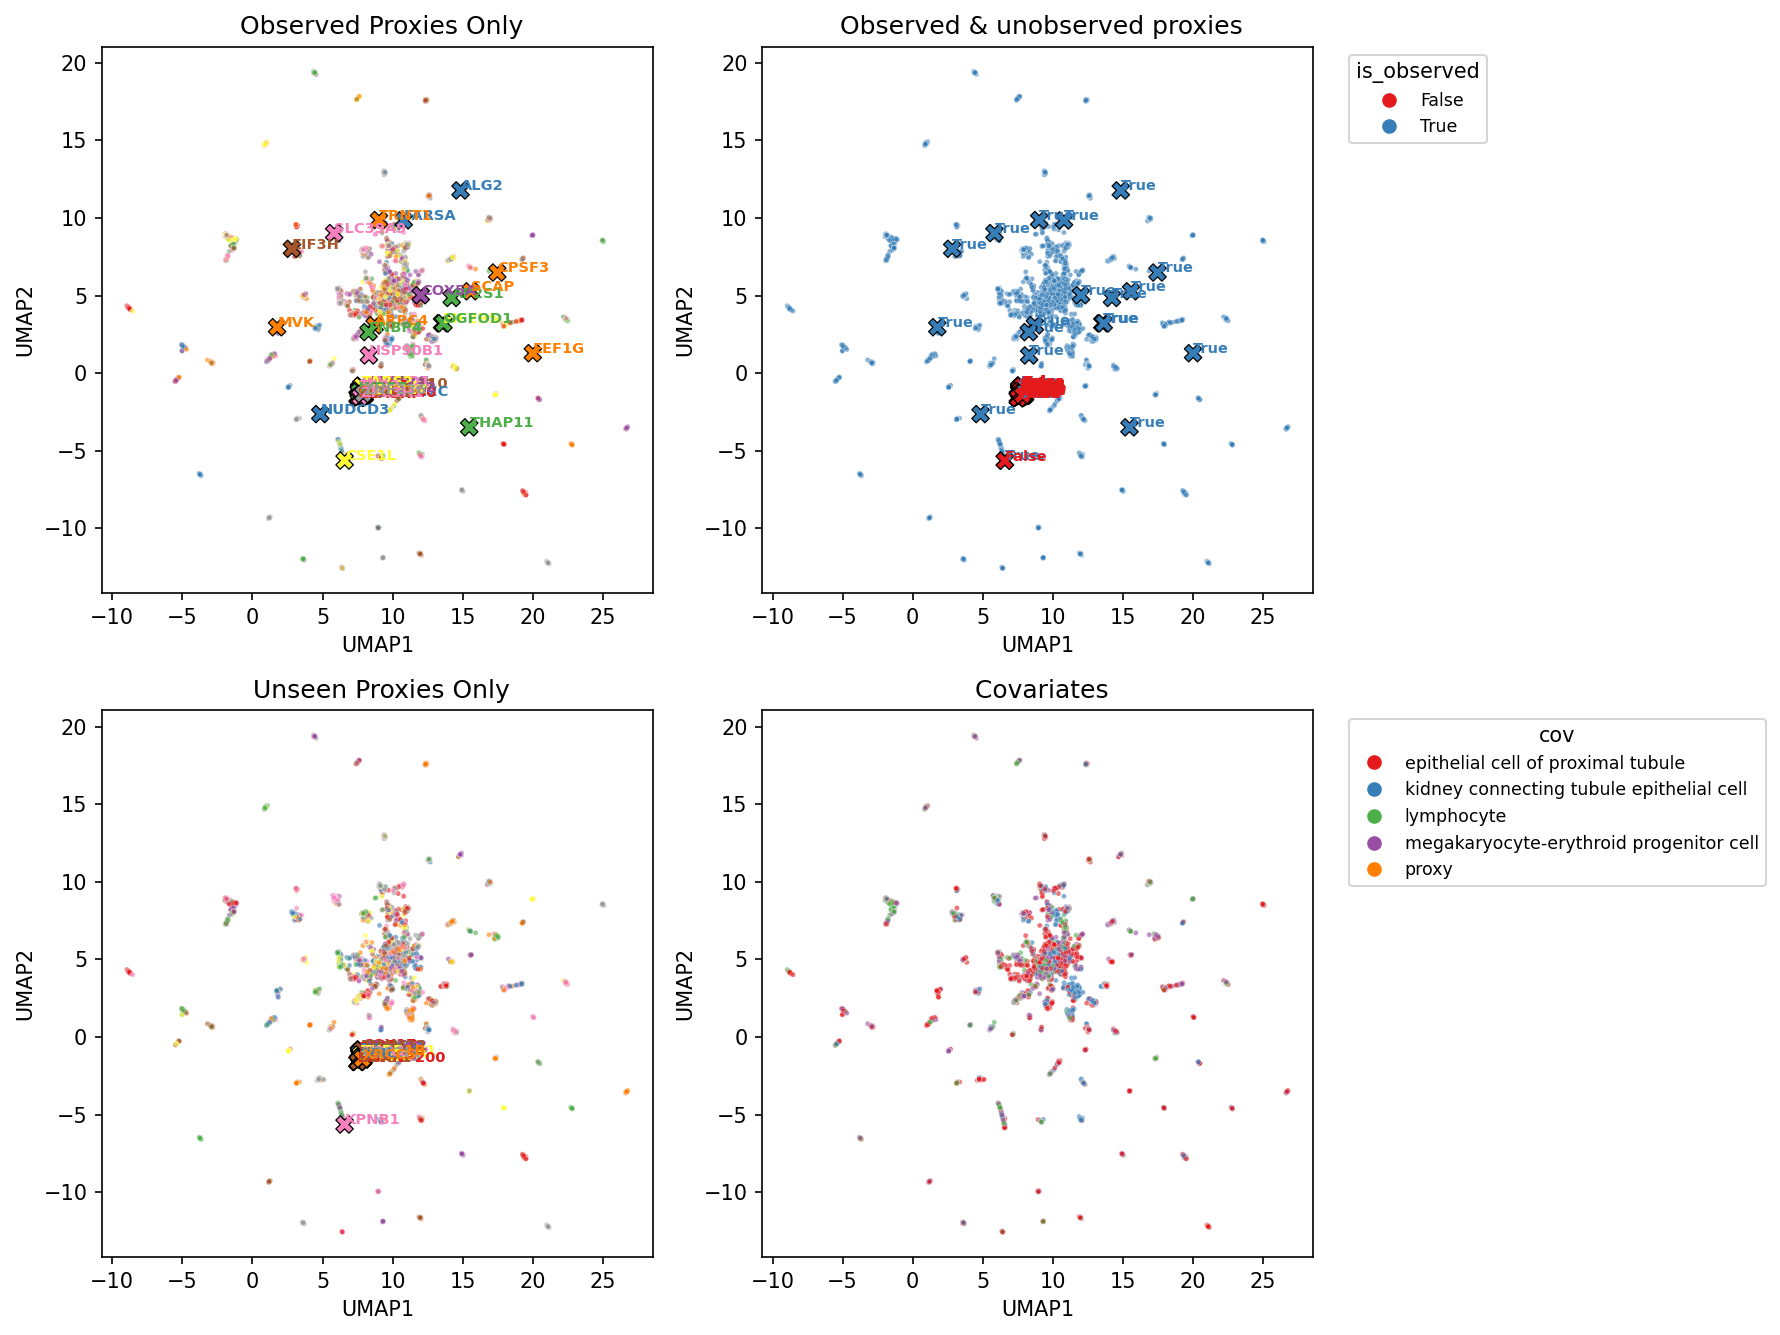

In [21]:
# Check out latent space with class proxies
import src.utils.plotting as pl

predictions = model.predict(indices=model._get_split_indices('val'), obs_only=False)
df, fig = pl.plot_umap_with_proxies(
    latent_space=predictions['z_shared'],
    cls_emb=predictions['cls_proj'],
    labels=predictions['label_idx'],
    covs=predictions['batch'],
    code_to_label=predictions['soft_predictions'].columns,
    n_obs=model.n_labels,
    palette='Set1'
)

In [22]:
# Load test data (unseen perturbations from an observed context during training)
#adata_p = '/home/xlv0877/proj_home/dl/data/merge/8a2a33dfa4d9a069/test/jurkat.h5ad'
adata_p = '/home/xlv0877/proj_home/dl/data/merge/8a2a33dfa4d9a069/train/all/nctx:5_ncls:431_minms:4_minc:100_minctx:5.h5ad'
#adata_p = '/home/xlv0877/proj_home/dl/perturb-seq/data/prepared/TianKampmann2019_day7neuron.h5ad'
adata = sc.read(adata_p)

In [23]:
# Remove unseen cell types
adata = adata[adata.obs.dataset!='ReplogleWeissman2025_Jurkat'].copy()

In [24]:
# Load 50 target zero-shot genes
target_genes_p = '/home/xlv0877/p32655/projects/perturbation_prediction/ExPert/resources/gene_embeddings/claude_sonnet_4.5/gene_descriptions_50_additional.json'
import json
target_genes = list(json.load(open(target_genes_p, 'r')).keys())

In [25]:
# Remove perturbations that are observed during training
obs_classes = model.idx_to_label[:model.n_labels]
unobs_classes = list(set(adata.obs.perturbation.unique()).intersection(set(model.idx_to_label)).difference(set(obs_classes)))
unobs_cls_adata = adata[adata.obs.perturbation.isin(target_genes)]

In [26]:
# Pick the top 10 unobserved classes with the highest support
top_n = 5
test_cls = unobs_cls_adata.obs.perturbation.value_counts().head(top_n).index.values
# Take subset testing data
test_adata = unobs_cls_adata[unobs_cls_adata.obs.perturbation.isin(test_cls)].copy()

In [27]:
# Setup anndata with model
ExPert.setup_anndata(test_adata, labels_key='perturbation', batch_key='context', categorical_covariate_keys=['dataset'])

[12/10/25 20:39:12] INFO     Registered class embedding from adata.uns[cls_embedding].

                    INFO     Registered context embedding from adata.uns[ctx_embedding].

In [28]:
# Predict test data
predictions = model.predict(test_adata, obs_only=False)

INFO     Received view of anndata, making copy.                                                                    


[12/10/25 20:39:17] INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup

                    INFO     Classifying.

[12/10/25 20:39:18] INFO     Aggregating predictions

                    INFO     Adding classification report.

In [29]:
%autoreload 0

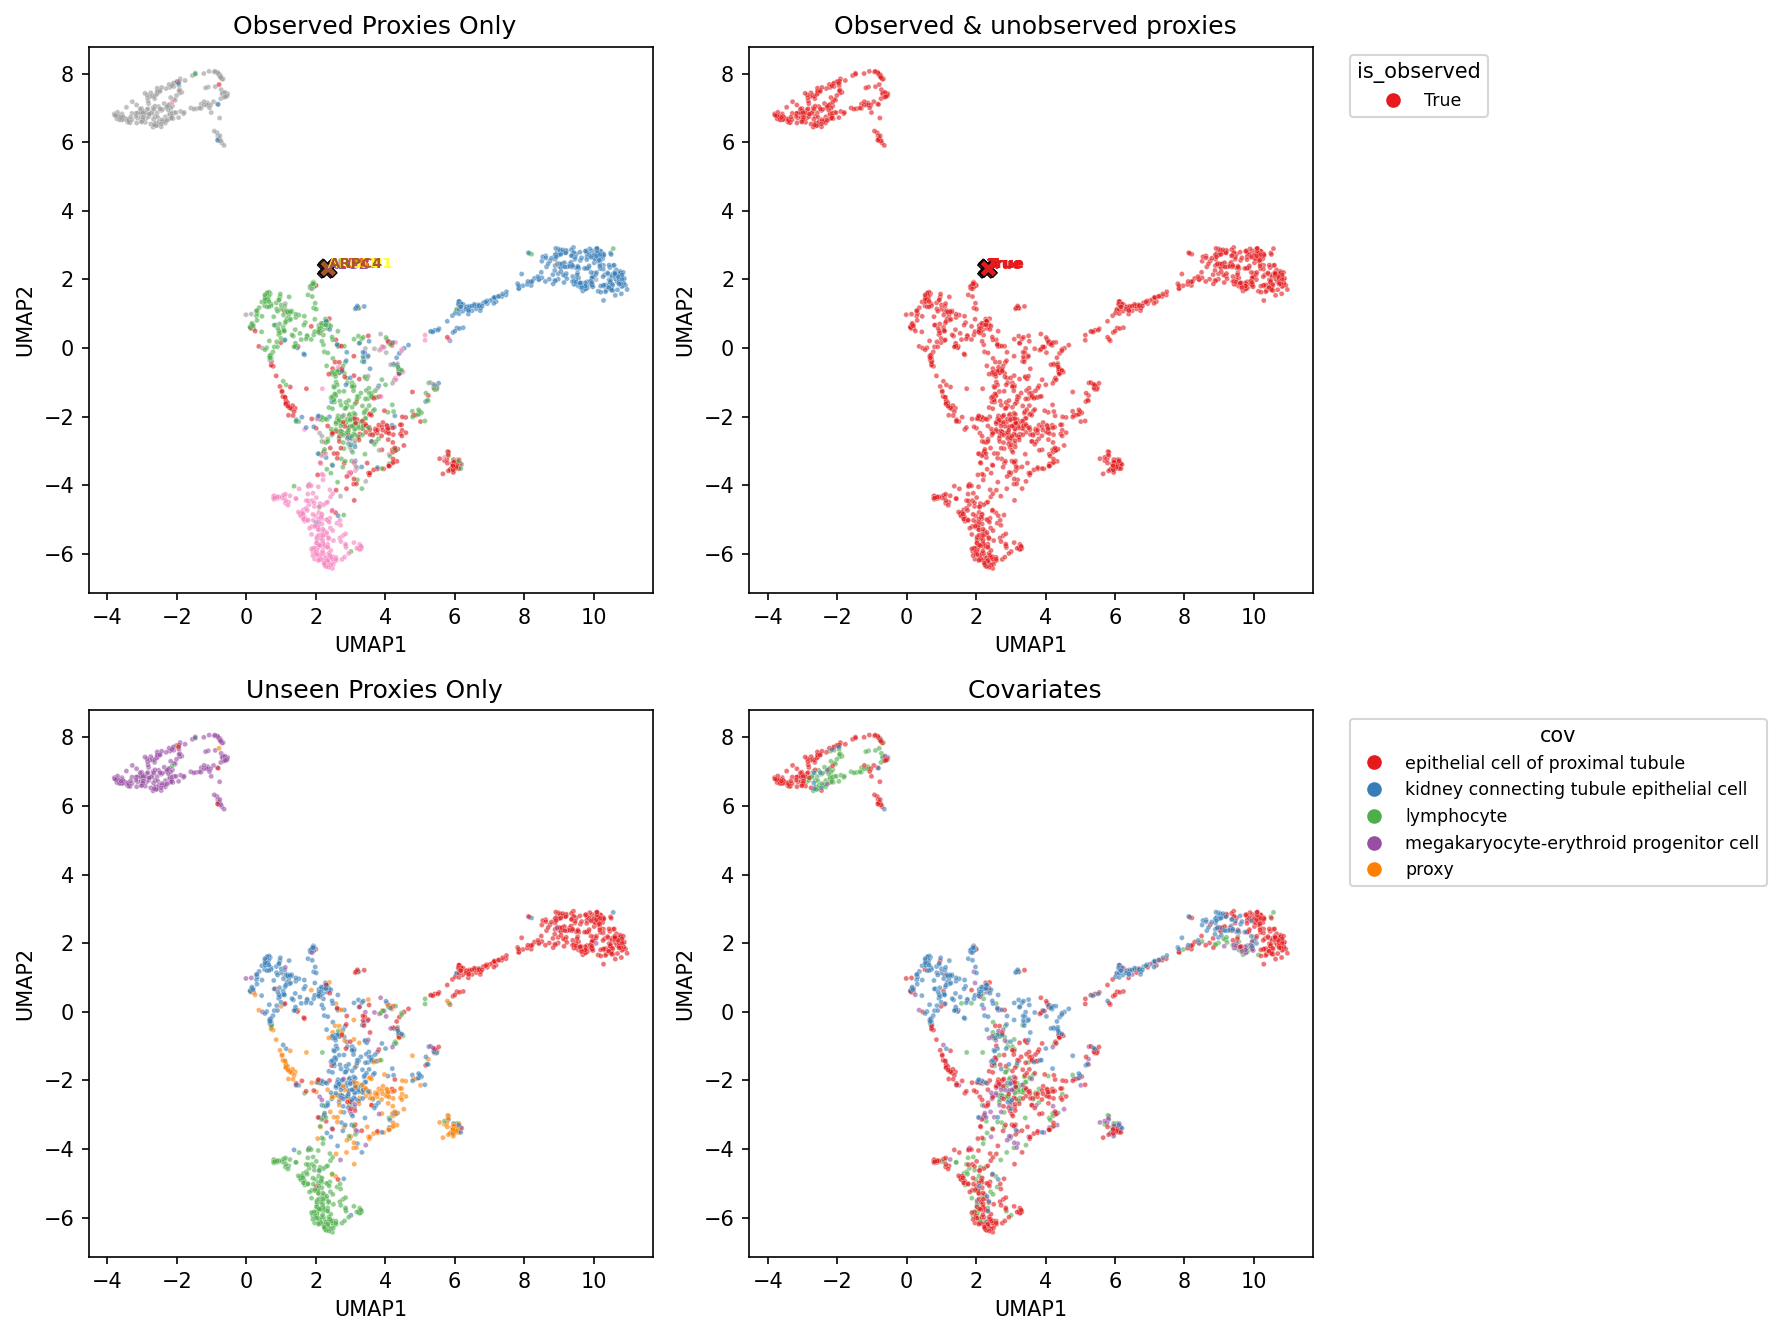

In [70]:
# Check out latent space with class proxies
import src.utils.plotting as pl

# Plot relevant unobserved proxies only
mask = np.isin(predictions['soft_predictions'].columns.values, test_cls)
proxy_idx = np.where(mask)[0]
df, fig = pl.plot_umap_with_proxies(
    latent_space=predictions['z_shared'],
    cls_emb=predictions['cls_proj'][proxy_idx],
    labels=predictions['label_idx'],
    covs=predictions['batch'],
    code_to_label=predictions['soft_predictions'].columns,
    n_obs=model.n_labels,
    palette='Set1'
)

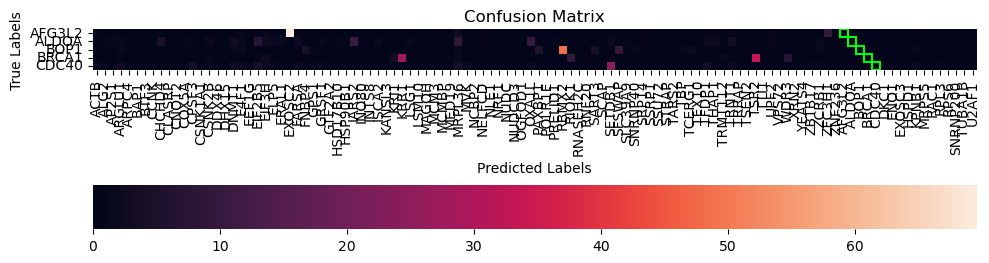

In [34]:
pl.plot_confusion_full(y_true=predictions['labels'], y_pred=predictions['prediction'], ref_labels=predictions['soft_predictions'].columns.values)

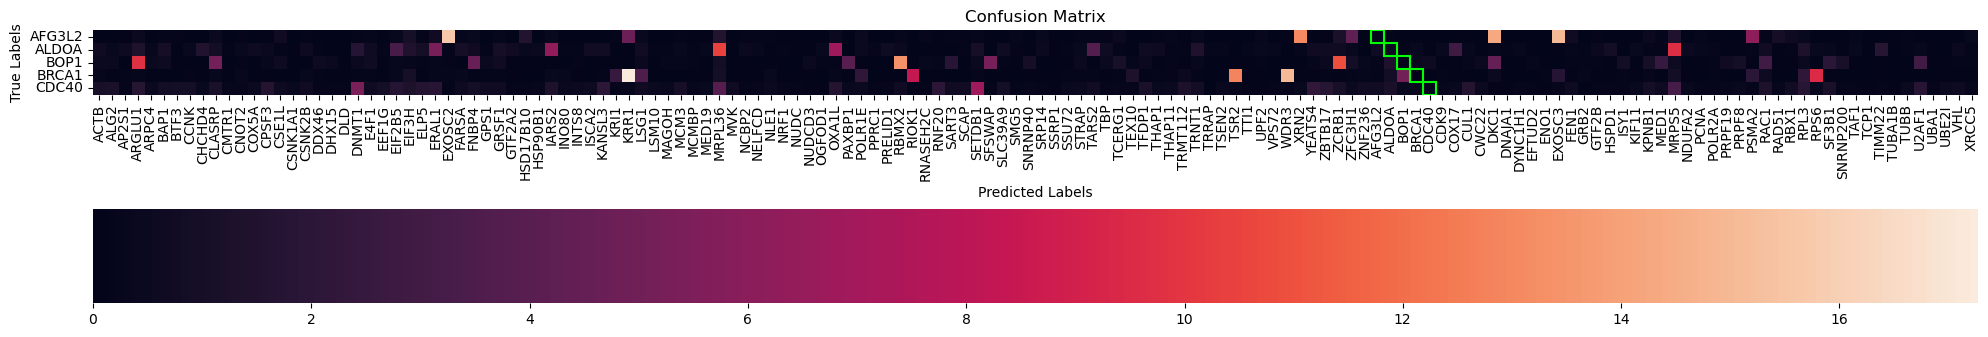

In [35]:
from src.utils.performance import get_topk_predictions
topk_true, topk_pred = get_topk_predictions(soft_preds=predictions['soft_predictions'].values, y_true=predictions['label_idx'], k=5)
topk_true = predictions['soft_predictions'].columns[topk_true]
topk_pred = predictions['soft_predictions'].columns[topk_pred]
pl.plot_confusion_full(y_true=topk_true, y_pred=topk_pred, ref_labels=predictions['soft_predictions'].columns.values, figsize=(20, 8))

In [36]:
predictions['cls_report'].sort_values('f1-score')

,precision,recall,f1-score,support,log_count
AFG3L2,NaN,0.0,0.0,408.0,6.011267
ALDOA,0.0,0.0,0.0,414.0,6.025866
BOP1,NaN,0.0,0.0,246.0,5.505332
BRCA1,0.0,0.0,0.0,264.0,5.575949
CDC40,NaN,0.0,0.0,233.0,5.451038
